## Importing Libraries

Tested on a virtual environment running Python version 3.12.8

In [2]:
!pip install pandas -q
!pip install wheel -q
!pip install ipywidgets -q
!pip install setuptools -q
!pip install xgboost -q
!pip install catboost -q
!pip install -U scikit-learn -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install ipympl -q
!pip install xgboost -q
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [45]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize, MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator
from datetime import datetime
import matplotlib.pyplot as plt
plt.close('all')
from math import log

import numpy as np
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

%matplotlib widget

## Time to Load the dataset

In [4]:
rent_df = pd.read_csv('after_fe.csv')
rent_df

,daysOnMarket,availableFrom,price,zip,beds,baths,latitude,longitude,hasVideo,PhotosNum,...,month_available,day_available,beds_baths_interaction,log_monthly_housing_costs,precinct_safety_rank_scaled,median_income_scaled,crime_to_safety_ratio,beds_to_baths_ratio,diversity_index,occupied_to_vacant_ratio
0,1.0,2024-11-25,1855.0,11212,1,1.0,40.662186,-73.922293,1,4,...,11,25,1.0,7.087574,1.393251,-1.454809,0.029137,0.500000,0.000074,13.157442
1,4.0,2024-11-22,2235.0,11212,2,1.0,40.663817,-73.924122,1,5,...,11,22,2.0,7.087574,1.393251,-1.454809,0.029137,1.000000,0.000074,13.157442
2,4.0,2024-11-22,1750.0,11212,1,1.0,40.668506,-73.917055,1,7,...,11,22,1.0,7.087574,1.539399,-1.454809,0.029947,0.500000,0.000074,13.157442
3,6.0,2024-11-20,1850.0,11212,1,1.0,40.657349,-73.917750,1,4,...,11,20,1.0,7.087574,1.393251,-1.454809,0.029137,0.500000,0.000074,13.157442
4,7.0,2024-11-19,3000.0,11212,3,1.0,40.659825,-73.922602,1,9,...,11,19,3.0,7.087574,1.393251,-1.454809,0.029137,1.500000,0.000074,13.157442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6966,121.0,2024-11-15,4070.0,10459,4,1.0,40.823948,-73.889854,0,0,...,11,15,4.0,7.188413,0.272790,-1.325090,0.032050,2.000000,0.000073,25.148305
6967,6.0,2024-11-15,3800.0,10307,3,3.0,40.513058,-74.249470,0,18,...,11,15,9.0,7.658228,-1.627123,0.668903,0.205292,0.750000,0.000001,20.458824
6968,5.0,2024-11-15,3750.0,10038,2,1.0,40.709580,-74.009330,0,5,...,11,15,2.0,7.921536,0.029211,0.069353,0.034026,1.000000,0.001610,5.254689
6969,10.0,2024-11-15,3200.0,10038,1,1.0,40.709370,-74.006035,0,0,...,11,15,1.0,7.921536,0.029211,0.069353,0.034026,0.500000,0.001610,5.254689


## Convert rent variable into a cateogrical variable

In [47]:

num_buckets = 3

# Create quantile-based buckets with integer labels
rent_df['rent_bucket'] = pd.qcut(rent_df['price'], q=num_buckets, labels=[i for i in range(num_buckets)])

# Display the bins and distribution
bin_edges = pd.qcut(rent_df['price'], q=num_buckets, retbins=True)[1]
distribution = rent_df['rent_bucket'].value_counts(normalize=True, sort=False)

label_to_range: dict[int, str] = {i: f"${bin_edges[i]:,.2f} - ${bin_edges[i+1]:,.2f}" for i in range(len(bin_edges) - 1)}

for i in range(len(bin_edges) - 1):
    print(f"Bucket {i+1}: ${bin_edges[i]:,.2f} - ${bin_edges[i+1]:,.2f} with {round(distribution.iloc[i]*100, ndigits=2)}% of data")

Bucket 1: $1,199.00 - $2,850.00 with 33.57% of data
Bucket 2: $2,850.00 - $3,800.00 with 33.14% of data
Bucket 3: $3,800.00 - $125,000.00 with 33.3% of data


In [48]:
rent_df.head()

,daysOnMarket,availableFrom,price,zip,beds,baths,latitude,longitude,hasVideo,PhotosNum,...,median_income_scaled,crime_to_safety_ratio,beds_to_baths_ratio,diversity_index,occupied_to_vacant_ratio,rent_bucket,availableFromDay,availableFromMonth,availableFromYear,Owner-Occupied Units
0,1.0,2024-11-25,1855.0,11212,1,1.0,40.662186,-73.922293,1,4,...,-1.454809,0.029137,0.5,0.000074,13.157442,0,25,11,2024,154.0
1,4.0,2024-11-22,2235.0,11212,2,1.0,40.663817,-73.924122,1,5,...,-1.454809,0.029137,1.0,0.000074,13.157442,0,22,11,2024,154.0
2,4.0,2024-11-22,1750.0,11212,1,1.0,40.668506,-73.917055,1,7,...,-1.454809,0.029947,0.5,0.000074,13.157442,0,22,11,2024,154.0
3,6.0,2024-11-20,1850.0,11212,1,1.0,40.657349,-73.917750,1,4,...,-1.454809,0.029137,0.5,0.000074,13.157442,0,20,11,2024,154.0
4,7.0,2024-11-19,3000.0,11212,3,1.0,40.659825,-73.922602,1,9,...,-1.454809,0.029137,1.5,0.000074,13.157442,1,19,11,2024,154.0


## Looking at the Dataframe

At some points, there was no census data available, so we drop those rows here.

In [49]:
nan_summary = rent_df.isnull().sum().to_frame(name='NaN Count')
nan_summary['Percentage'] = (nan_summary['NaN Count'] / len(rent_df)) * 100
nan_summary

,NaN Count,Percentage
daysOnMarket,0,0.0
availableFrom,0,0.0
price,0,0.0
zip,0,0.0
beds,0,0.0
...,...,...
rent_bucket,0,0.0
availableFromDay,0,0.0
availableFromMonth,0,0.0
availableFromYear,0,0.0


## Little Feature Modification

In [50]:
rent_df['availableFromDay'] = rent_df['availableFrom'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').day)
rent_df['availableFromMonth'] = rent_df['availableFrom'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
rent_df['availableFromYear'] = rent_df['availableFrom'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)
rent_df['Owner-Occupied Units'] = rent_df['Owner-Occupied Units (value < $100,000)']

features_min_max = ['longitude', 'latitude', 'Median Household Income', 
                    'Monthly Housing Costs', 'crime_rate', 'beds_baths_interaction', 
                    'beds_to_baths_ratio']
features_log_transform = ['crime_to_safety_ratio', 'occupied_to_vacant_ratio']
features_standardize = ['diversity_index', 'PhotosNum']
features_to_amplify = ['diversity_index']

rent_df_transformed = rent_df.copy()

min_max_scaler = MinMaxScaler()
rent_df_transformed[features_min_max] = min_max_scaler.fit_transform(rent_df_transformed[features_min_max])

for feature in features_log_transform:
    rent_df_transformed[feature] = np.log1p(rent_df_transformed[feature])

standard_scaler = StandardScaler()
rent_df_transformed[features_standardize] = standard_scaler.fit_transform(rent_df_transformed[features_standardize])

for feature in features_to_amplify:
    rent_df_transformed[feature] = rent_df_transformed[feature] * 100


rent_df_transformed.drop(columns=['availableFrom', 'Owner-Occupied Units (value < $100,000)'], inplace=True)

rent_df_transformed.to_csv('after_transformations.csv', index=False)

print(rent_df_transformed.columns)

assert 'Owner-Occupied Units (value < $100,000)' not in set(rent_df_transformed.columns), 'This column should have been dropped'

Index(['daysOnMarket', 'price', 'zip', 'beds', 'baths', 'latitude',
       'longitude', 'hasVideo', 'PhotosNum', 'Number of Households',
       'Median Household Income', 'Per Capita Income',
       'Total Income Distribution', 'Median Gross Rent', 'Median Home Value',
       'Occupied Housing Units', 'Vacant Housing Units',
       'Monthly Housing Costs', 'Precinct', 'schools_in_precinct',
       'nearby_subway_stations', 'crime_rate', 'precinct_safety_rank',
       'Median Age_ratio', 'Male Population_ratio', 'Female Population_ratio',
       'White Alone_ratio', 'Black or African American Alone_ratio',
       'Asian Alone_ratio', 'Hispanic or Latino_ratio',
       'Population Below Poverty Level_ratio', 'Employed_ratio',
       'Unemployed_ratio', 'High School Graduate (Age 25+)_ratio',
       'Bachelor’s Degree (Age 25+)_ratio',
       'Graduate or Professional Degree (Age 25+)_ratio',
       'Never Married_ratio', 'Currently Married_ratio', 'Divorced_ratio',
       'borough_Brookl

## Time to split our dataset

In [51]:
X = rent_df_transformed.drop(columns=['price', 'rent_bucket'])
y = rent_df_transformed['rent_bucket']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training

### CatBoost

We start experimenting with training using Catboost because it doesn't need any categorical data to be encoded in any way or form. 

In [33]:
# Initialize and train CatBoost
# model = CatBoostClassifier(cat_features=cat_features, task_type='MPS')
# grid_search_result = model.grid_search(param_grid, X=X_train, y=y_train, plot=True)

# Make predictions
# y_pred = model.predict(X_test)

In [11]:
fin_model = CatBoostClassifier(iterations=900, depth=8, l2_leaf_reg=5.5, bagging_temperature=0.7, border_count=64, grow_policy='Depthwise', boosting_type='Plain')
fin_model.fit(X_train, y_train)

y_pred = fin_model.predict(X_test)

0:	learn: 1.7624468	total: 81.7ms	remaining: 1m 13s
1:	learn: 1.7367206	total: 101ms	remaining: 45.5s
2:	learn: 1.7121458	total: 120ms	remaining: 35.9s
3:	learn: 1.6880231	total: 140ms	remaining: 31.4s
4:	learn: 1.6651383	total: 159ms	remaining: 28.5s
5:	learn: 1.6433068	total: 177ms	remaining: 26.4s
6:	learn: 1.6234355	total: 197ms	remaining: 25.1s
7:	learn: 1.6043441	total: 216ms	remaining: 24.1s
8:	learn: 1.5860653	total: 237ms	remaining: 23.4s
9:	learn: 1.5692870	total: 257ms	remaining: 22.8s
10:	learn: 1.5525235	total: 276ms	remaining: 22.3s
11:	learn: 1.5361183	total: 295ms	remaining: 21.9s
12:	learn: 1.5217012	total: 315ms	remaining: 21.5s
13:	learn: 1.5072955	total: 335ms	remaining: 21.2s
14:	learn: 1.4913873	total: 354ms	remaining: 20.9s
15:	learn: 1.4775245	total: 373ms	remaining: 20.6s
16:	learn: 1.4644472	total: 391ms	remaining: 20.3s
17:	learn: 1.4531591	total: 410ms	remaining: 20.1s
18:	learn: 1.4411700	total: 428ms	remaining: 19.9s
19:	learn: 1.4300414	total: 447ms	remai

In [12]:
cat_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {cat_accuracy:.2f}")

Accuracy: 0.55


## ROC-AUC Time

In [13]:
# Get predicted probabilities for all classes
y_pred_proba = fin_model.predict_proba(X_test)

# Binarize the output labels for multi-class AUC
# Converts y_test to a binary matrix of shape (n_samples, n_classes)
y_test_binarized = label_binarize(y_test, classes=[x for x in range(num_buckets)])  # Adjust classes as per your dataset

# print(y_test_binarized)

# Compute the multi-class ROC AUC score
roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovo")  # "ovo" is another option
print(f"Multi-Class ROC AUC Score: {roc_auc:.4f}")

Multi-Class ROC AUC Score: 0.8661


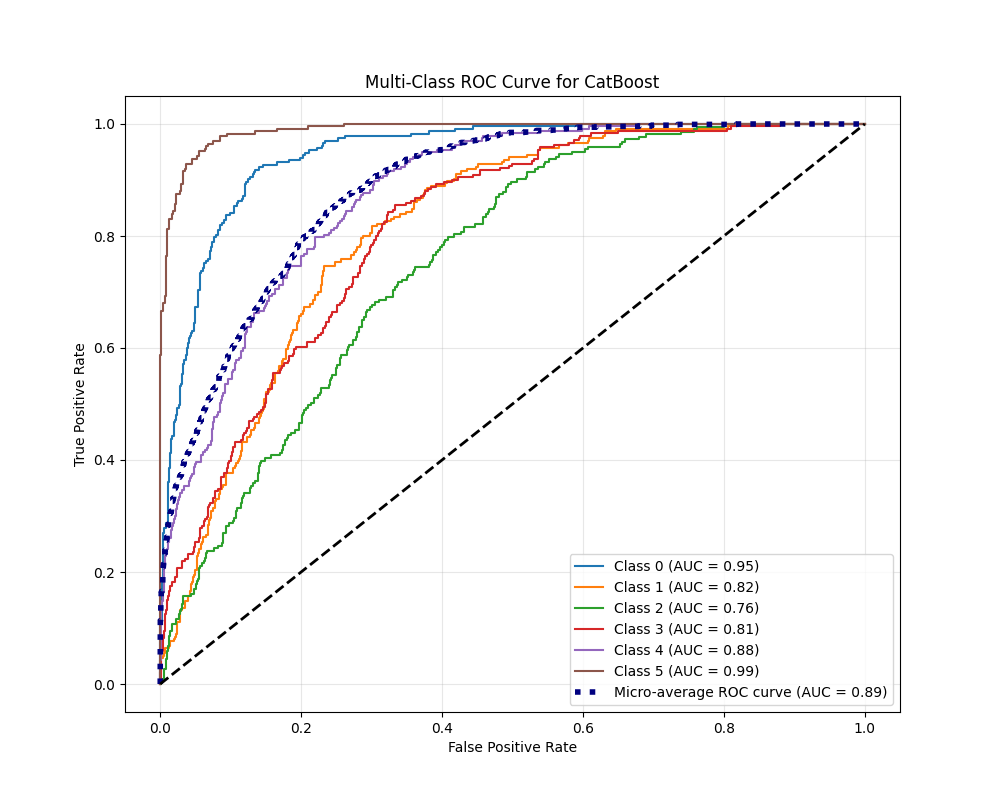

In [14]:
# Get predicted probabilities for all classes
y_pred_proba = fin_model.predict_proba(X_test)

# Binarize the output labels for multi-class AUC
y_test_binarized = label_binarize(y_test, classes=[x for x in range(num_buckets)])  # Adjust classes as per your dataset

# Initialize variables for the ROC curves
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and AUC for each class
for i in range(num_buckets):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_buckets):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
         color='navy', linestyle=':', linewidth=4)

# Plot diagonal line for random chance
plt.plot([0, 1], [0, 1], "k--", linewidth=2)

# Add plot details
plt.title("Multi-Class ROC Curve for CatBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Confusion Matrix Time

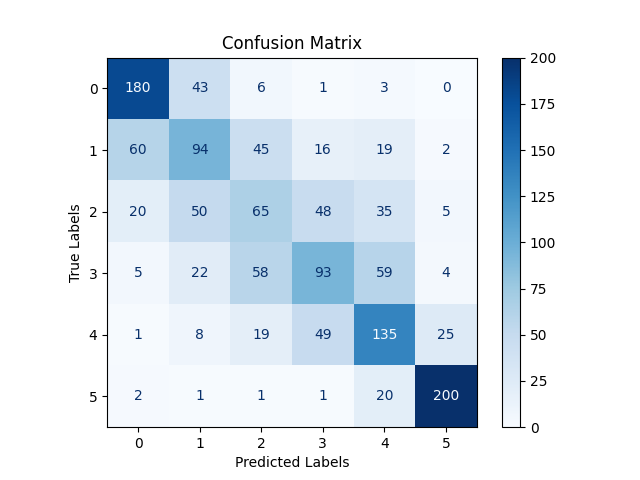

In [15]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=fin_model.classes_)
disp.plot(cmap=plt.cm.Blues)

# Beautify the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Interesting Observation

We notice That our model gets the class right or predicts the class right next to it so we think it would be interesting to come up with a relaxed accuracy metric, which will think that the predicted class is correct if it is Numeric adjacent to the correct class

In [16]:
def relaxed_accuracy(y_true, y_pred):
    """
    Calculates accuracy with ±1 tolerance for class predictions.
    
    Parameters:
    y_true (array-like): True class labels.
    y_pred (array-like): Predicted class labels.
    
    Returns:
    float: Relaxed accuracy score.
    """
    # Count correct predictions with ±1 tolerance
    correct = sum(abs(true - pred) <= 1 for true, pred in zip(y_true, y_pred))
    
    # Calculate accuracy
    accuracy = correct / len(y_true)
    
    return accuracy

accuracy = relaxed_accuracy(y_test, y_pred)
print(f"Relaxed Accuracy (±1): {accuracy[0]:.2f}")


Relaxed Accuracy (±1): 0.88


## Weighted Relaxed Accuracy

It's not fair to weight being one class off the true class. So here we propose (casually) a generic function that gives a weighted relaxed accuracy. It wieghts accoridngly 
1. 	Distance Sensitivity:
Classes that are further apart in index (e.g., true class = 5, predicted class = 7) incur a greater penalty than classes that are closer (e.g., predicted = 4 or 6).
2. Range Sensitivity:
Predictions that are off by a class whose range is large are penalized more than predictions off by a class with a smaller range. For instance, guessing a bucket spanning 1000 units is considered a larger error than guessing one spanning 200 units.

In [17]:
bucket_ranges: dict[int, float] = {i: (bin_edges[i+1] - bin_edges[i]) * distribution.iloc[i] for i in range(num_buckets)}

max_range = sum(bucket_ranges.values())
normalized_bucket_ranges = {k: (log(v + 1, 1.04) / log(max_range + 1, 15))/10 for k, v in bucket_ranges.items()}

print(normalized_bucket_ranges)

{0: 3.6968081547604053, 1: 3.0117422381559713, 2: 3.003695849033415, 3: 3.0824949337696017, 4: 3.843003321551098, 5: 6.881050296325381}


In [18]:
def get_penalty(t, p, bucket_ranges, bucket_range_relaxation:float, max_range:float, penalty_weight:float):
    distance = abs(t - p) * penalty_weight
    # Average the true and predicted bucket ranges
    avg_range = avg_range = (bucket_ranges[t] + bucket_ranges[p]) / (bucket_range_relaxation + bucket_ranges[t] + bucket_ranges[p])
    # Compute penalty proportional to distance and relative range
    # The larger the distance and avg_range, the greater the penalty.
    penalty = (distance * (avg_range / max_range))
    return penalty

def relaxed_accuracy_with_weighted_ranges(true_labels, pred_labels, bucket_ranges, min_partial_credit:float=0.08, bucket_range_relaxation:float=1.2, grace_threshold:float = 0.08, penalty_weight:float=1.5, unpack_labels:bool=False, verbose:bool=False):
    """
    Calculate a "relaxed accuracy" that gives:
    - Full credit (1.0) if prediction == true class.
    - Partial credit if prediction is incorrect, with the score decreasing
      as the class distance and bucket ranges increase.
    - A minimum partial credit is guaranteed for any incorrect prediction 
      so that, on average, relaxed accuracy >= strict accuracy.
    Parameters
    ----------
    true_labels : array-like of shape (n_samples,)
        True class labels.
    pred_labels : array-like of shape (n_samples,)
        Predicted class labels.
    bucket_ranges : dict[int, float]
        A dictionary mapping each class label to its weighted bucket range.
        A higher float value means a larger bucket range.
        
    Returns
    -------
    float
        The mean relaxed accuracy across all predictions.
    """

    assert 0 <= min_partial_credit <= 1, 'min_partial_credit has to between 0 and 1'
    
    max_range = max(bucket_ranges.values()) 
    min_partial_credit = 0.08

    grace_count = 0
    tot = 0
    
    scores = []
    for t, p in zip(true_labels, pred_labels):
        tot += 1
        if unpack_labels:
            p = p[0]

        penalty = get_penalty(t, p, bucket_ranges, bucket_range_relaxation, max_range, penalty_weight)

        score = max(1 - penalty, 0)
        if score < grace_threshold:
            score += min_partial_credit
            grace_count += 1
        
        scores.append(score)
    if verbose:
        print(f"Grace was given to {grace_count*100/tot}% of predictions.")
        
    return np.mean(scores)

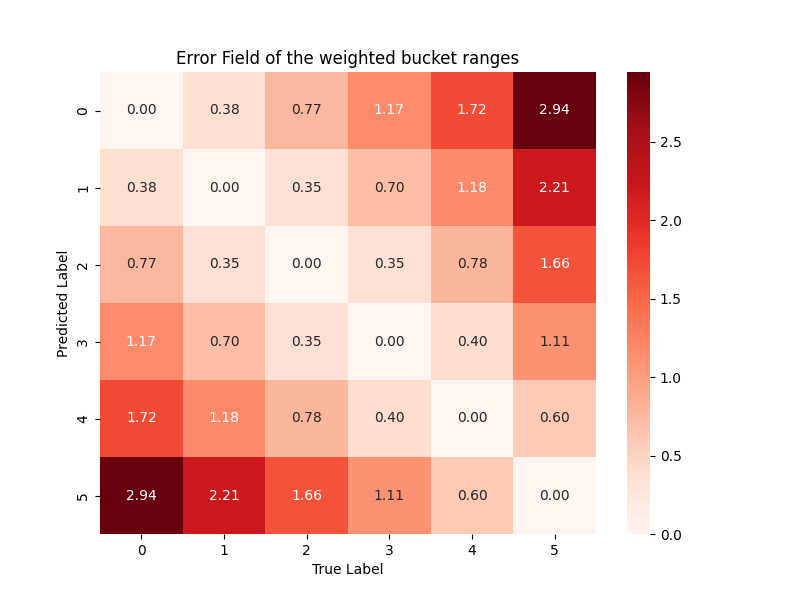

In [19]:
def calculate_err_field(bucket_ranges:dict[int, float]):
    err_field = np.zeros((num_buckets, num_buckets))
    max_range = max(bucket_ranges.values()) 
    for i in range(num_buckets):
        for j in range(num_buckets):
            err_field[i][j] = get_penalty(i, j, bucket_ranges, 120, max_range=max_range, penalty_weight=50)
    return err_field

err_field = calculate_err_field(normalized_bucket_ranges)

plt.figure(figsize=(8, 6))
sns.heatmap(err_field, annot=True, fmt=".2f", cmap="Reds", cbar=True)

plt.title("Error Field of the weighted bucket ranges")
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()


## 3D visualisation

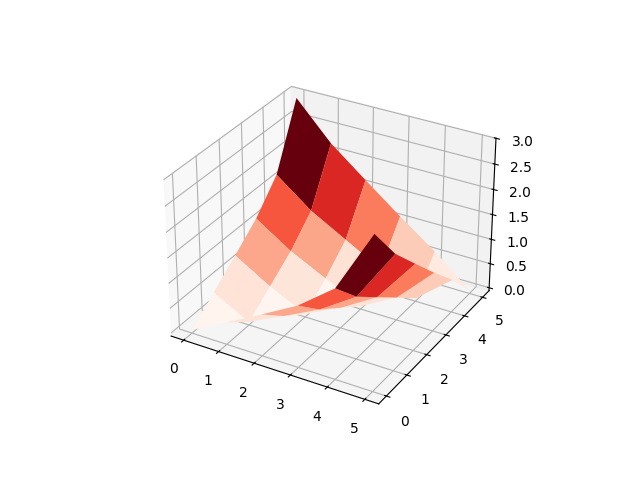

In [20]:
x = np.arange(err_field.shape[1])
y = np.arange(err_field.shape[0])
X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, err_field, cmap='Reds')
plt.show()

In [21]:
print(relaxed_accuracy_with_weighted_ranges(y_test, y_pred, normalized_bucket_ranges, penalty_weight=3.5, unpack_labels=True))

0.7510117164877271


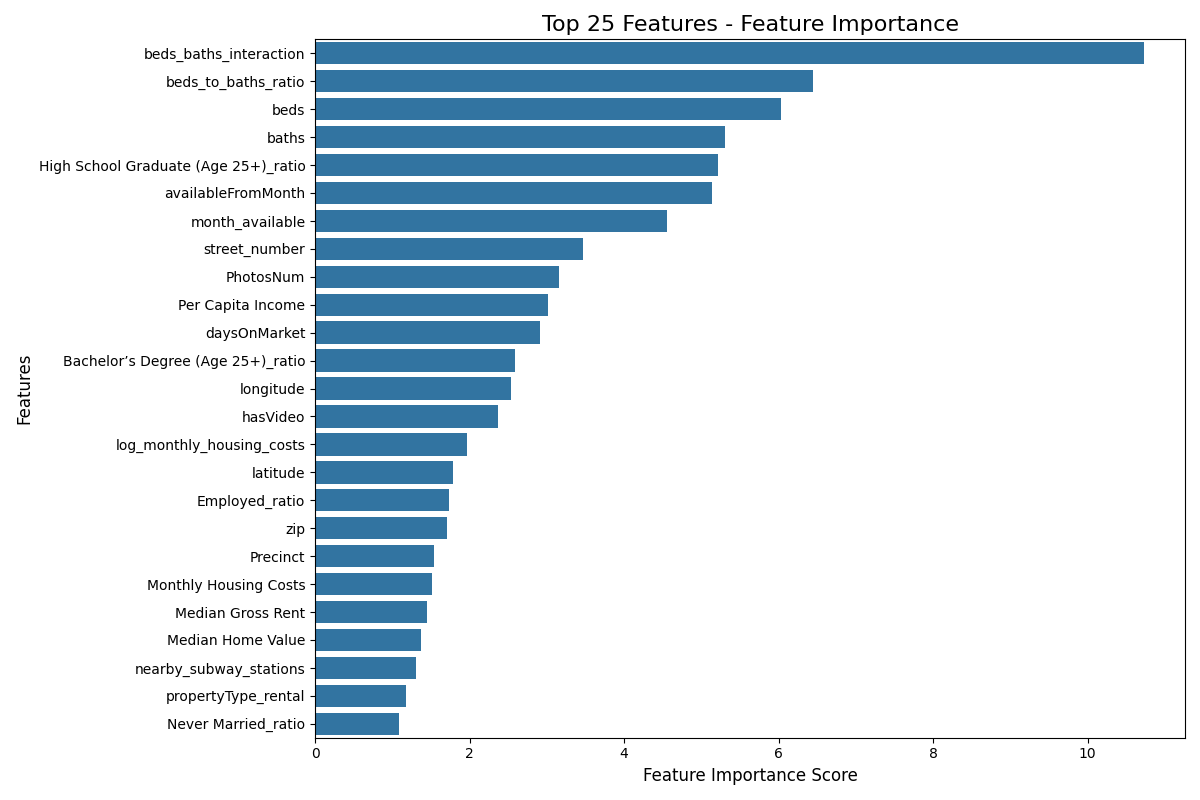

In [22]:

feature_importance = fin_model.get_feature_importance()
feature_names = X_train.columns

# Combine into a DataFrame for easier visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

top_20_features = importance_df.head(25)

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=top_20_features, 
    orient='h'
)

# Customize the plot
plt.title('Top 25 Features - Feature Importance', fontsize=16)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

## Custom Loss function

Let's see what happens if we use our error field as a loss function to train the model

In [46]:
class CustomLoss:
    def __init__(self, error_matrix):

        self.error_matrix = error_matrix  # Error field as a NumPy array

        print(self.error_matrix)
        

    def calc_ders_multi(self, approxes, target, weights):
        """
        Calculate the gradient (first derivative) and Hessian (second derivative) 
        for a single sample.

        Parameters:
        - approxes: 1D array of predicted logits for one sample.
        - targets: 1D array containing the true label for this sample.
        - weights: Optional sample weights (not used here).

        Returns:
        - Tuple (gradient, hessian).
        """
        # Convert logits to probabilities using softmax

        print("Start calc_ders_multi")
        print(f"approxes: {approxes}, type: {type(approxes)}, shape: {np.shape(approxes)}")
        print(f"target: {target}, type: {type(target)}")
        print(f"weights: {weights}")

        try:
            probabilities = np.exp(approxes - np.max(approxes))
            probabilities /= np.sum(probabilities)
            print(f"Probabilities: {probabilities}")
        except Exception as e:
            print(f"Error during probabilities calculation: {e}")
            raise

        assert len(approxes) == self.error_matrix.shape[0], "approxes must equal error_matrix in length"
        print("done 1")

        probabilities = np.exp(approxes - np.max(approxes))
        probabilities /= np.sum(probabilities)

        assert len(probabilities) == self.error_matrix.shape[0], "probabilities must equal error_matrix in length"

        assert len(probabilities) == self.error_matrix.shape[0], "probabilities must equal error_matrix in length"

        print("done 2")

        # target = targets  # True class label
        grad = np.zeros_like(probabilities)
        hess = np.zeros_like(probabilities)

        assert target < self.error_matrix.shape[0], "target must be within error_matrix shape"
        assert grad.shape[0] == self.error_matrix.shape[0], 'hmm'

        print('done 3')

        for pred_class in range(len(probabilities)):
            assert int(target) < self.error_matrix.shape[0], "target must be within error_matrix shape"
            assert pred_class < self.error_matrix.shape[0], "pred_class must be within error_matrix shape"

            print("done 4")
            error = self.error_matrix[int(target), pred_class]

            if pred_class == target:
                grad[pred_class] = probabilities[pred_class] - 1  # Gradient for true class
                hess[pred_class] = probabilities[pred_class] * (1 - probabilities[pred_class])  # Hessian
            else:
                grad[pred_class] = probabilities[pred_class]  # Gradient for other classes
                hess[pred_class] = probabilities[pred_class] * (1 - probabilities[pred_class])  # Hessian

            # Scale gradients and Hessians by the error matrix value
            grad[pred_class] *= error
            hess[pred_class] *= error
        
        assert grad.shape == hess.shape, "grad must equal hess in shape"
        print("done 5")

        return grad, hess # Return score for the sample and weight of 1

## Supplying my own accuracy metric to the model

In [47]:


class RelaxedAccuracyMetric:
    def __init__(self, error_matrix, grace_threshold=0.05, min_partial_credit=0.08, verbose=False):
        """
        Initialize the RelaxedAccuracyMetric class.
        
        Parameters:
        - bucket_ranges: Dictionary mapping class labels to range weights.
        - min_partial_credit: Minimum credit given for incorrect predictions.
        - bucket_range_relaxation: Relaxation factor for range averaging.
        - grace_threshold: Score below which minimum partial credit is applied.
        - verbose: Whether to print additional information.
        """
        self.error_matrix = error_matrix
        self.verbose = verbose
        self.grace_threshold = grace_threshold
        self.min_partial_credit = min_partial_credit

    def get_final_error(self, error, weight):
        """
        Calculate the final error based on weighted error sum.
        
        Parameters:
        - error: The list of error values.
        - weight: The list of weights.
        
        Returns:
        - Weighted average error.
        """
        return np.sum(error) / np.sum(weight)

    def is_max_optimal(self):
        """
        Indicates whether a higher metric value is better.
        
        Returns:
        - True (higher metric values are better).
        """
        return True

    def evaluate(self, approxes, targets, weights=None):
        """
        Evaluate the relaxed accuracy for CatBoost.

        Parameters:
        - approxes: Predicted logits or probabilities (1D array for one sample).
        - targets: True class label (scalar or 1D array).
        - weights: Optional sample weights (not applicable for individual evaluation).

        Returns:
        - Tuple (average relaxed accuracy, total weight sum for the batch).
        """
        assert len(approxes) == 8, "approxes must equal error_matrix in length"
        assert len(approxes.shape) == 1, "Not Okay"
        
        if len(approxes.shape) == 1:  # Single sample
            probabilities = np.exp(approxes - np.max(approxes))
            probabilities /= np.sum(probabilities)

            assert len(probabilities) == self.error_matrix.shape[0], "probabilities must equal error_matrix in length"

            pred_class = np.argmax(probabilities)
            target = targets  # Extract scalar target for this sample

            penalty = self.error_matrix[int(target), pred_class]
            score = max(1 - penalty, 0)
            if score < self.grace_threshold:
                score += self.min_partial_credit

            return score, 1  # Return score for the sample and weight of 1
        else:
            raise ValueError("RelaxedAccuracyMetric received unexpected batch input.")

In [48]:
# custom_loss_model = CatBoostClassifier(cat_features=cat_features, iterations=900, depth=8, l2_leaf_reg=5.5, bagging_temperature=0.7, border_count=64, grow_policy='Depthwise', boosting_type='Plain', loss_function=CustomLoss(err_field), eval_metric=RelaxedAccuracyMetric(err_field), classes_count=num_buckets)
# custom_loss_model.fit(X_train, y_train)

y_pred = custom_loss_model.predict(X_test)

NameError: name 'custom_loss_model' is not defined

In [ ]:
print(relaxed_accuracy_with_weighted_ranges(y_test, y_pred, normalized_bucket_ranges))

# XGBOOST Time

In [52]:
xgb_clf = XGBClassifier(
    n_estimators=100,      # Number of trees
    learning_rate=0.1,     # Step size shrinkage
    max_depth=6,           # Maximum tree depth
    random_state=42        # Random seed for reproducibility
)

xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)

In [53]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.74


In [54]:
# Get predicted probabilities for all classes
y_pred_proba = xgb_clf.predict_proba(X_test)

# Binarize the output labels for multi-class AUC
# Converts y_test to a binary matrix of shape (n_samples, n_classes)
y_test_binarized = label_binarize(y_test, classes=[x for x in range(num_buckets)])  # Adjust classes as per your dataset

# print(y_test_binarized)

# Compute the multi-class ROC AUC score
roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovo")  # "ovo" is another option
print(f"Multi-Class ROC AUC Score: {roc_auc:.4f}")

Multi-Class ROC AUC Score: 0.9010


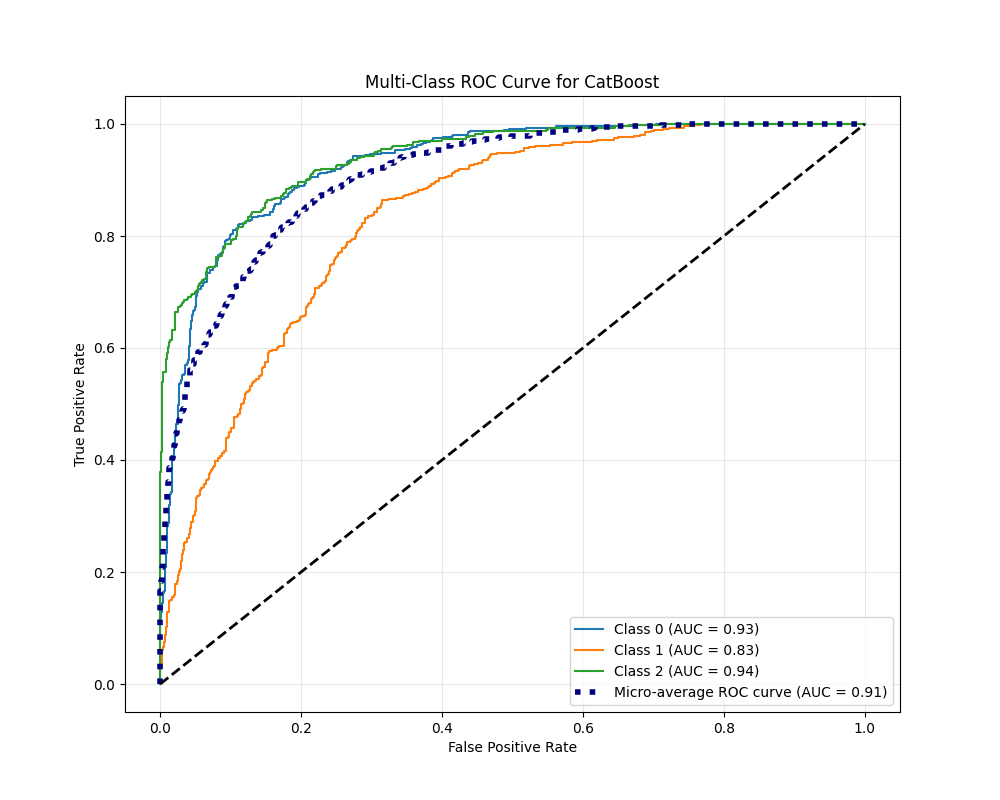

In [55]:
# Get predicted probabilities for all classes
y_pred_proba = xgb_clf.predict_proba(X_test)

# Binarize the output labels for multi-class AUC
y_test_binarized = label_binarize(y_test, classes=[x for x in range(num_buckets)])  # Adjust classes as per your dataset

# Initialize variables for the ROC curves
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and AUC for each class
for i in range(num_buckets):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_buckets):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
         color='navy', linestyle=':', linewidth=4)

# Plot diagonal line for random chance
plt.plot([0, 1], [0, 1], "k--", linewidth=2)

# Add plot details
plt.title("Multi-Class ROC Curve for CatBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

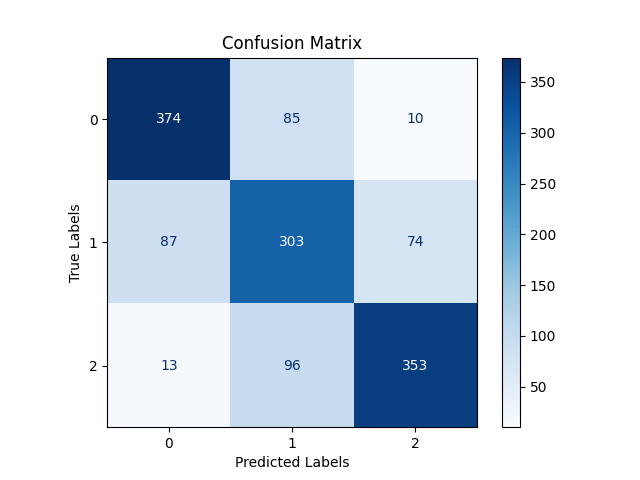

In [57]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot(cmap=plt.cm.Blues)

# Beautify the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [28]:
accuracy = relaxed_accuracy(y_test, y_pred)
print(f"Relaxed Accuracy (±1): {accuracy:.2f}")

Relaxed Accuracy (±1): 0.87


In [58]:
print(relaxed_accuracy_with_weighted_ranges(y_test, y_pred, normalized_bucket_ranges, penalty_weight=3.5))

0.8809001522213831


In [59]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SklearnXGBClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = XGBClassifier(**kwargs)

    def fit(self, X, y, **kwargs):
        self.model.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        return self.model.get_params(deep)

    def set_params(self, **params):
        self.model.set_params(**params)
        return self

In [31]:
# Initialize the XGBoost classifier


xgb_clf = SklearnXGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of boosting rounds
    'max_depth': [5, 6, 7],               # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2],    # Step size shrinkage
    'subsample': [0.9, 1.0, 1.1],              # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.7, 0.8]        # Subsample ratio of columns when constructing each tree
}


In [32]:
# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',   # Evaluation metric
    cv=3,                 # Number of cross-validation folds
    verbose=1,
    n_jobs=-1             # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/Users/utkarsh/Desktop/Utkarsh/NYU/Year 2/Semester 1/DS/Project/rent-raja/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:59:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/utkarsh/Desktop/Utkarsh/NYU/Year 2/Semester 1/DS/Project/rent-raja/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:59:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/utkarsh/Desktop/Utkarsh/NYU/Year 2/Semester 1/DS/Project/rent-raja/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:59:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/utkarsh/Desktop/Utkarsh/NYU/Year 2/Semester 1/DS/Project/rent-raja/.venv/lib/p

GridSearchCV(cv=3,
             estimator=SklearnXGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learni...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='binary:logistic', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [5, 6, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.9, 1.0, 1.1]},
             scoring='accuracy', verbose=1)

In [36]:




# Retrieve the best parameters and estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print(f"Best Parameters: {best_params}")

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy:.2f}")


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Test Set Accuracy: 0.56


In [37]:
xgb_clf = XGBClassifier(
    n_estimators=100,      # Number of trees
    learning_rate=0.1,     # Step size shrinkage
    max_depth=5,           # Maximum tree depth
    random_state=42,
    colsample_bytree=0.8,       # Random seed for reproducibility,
    subsample=1.0
)

xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)

In [38]:
xgb_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.56


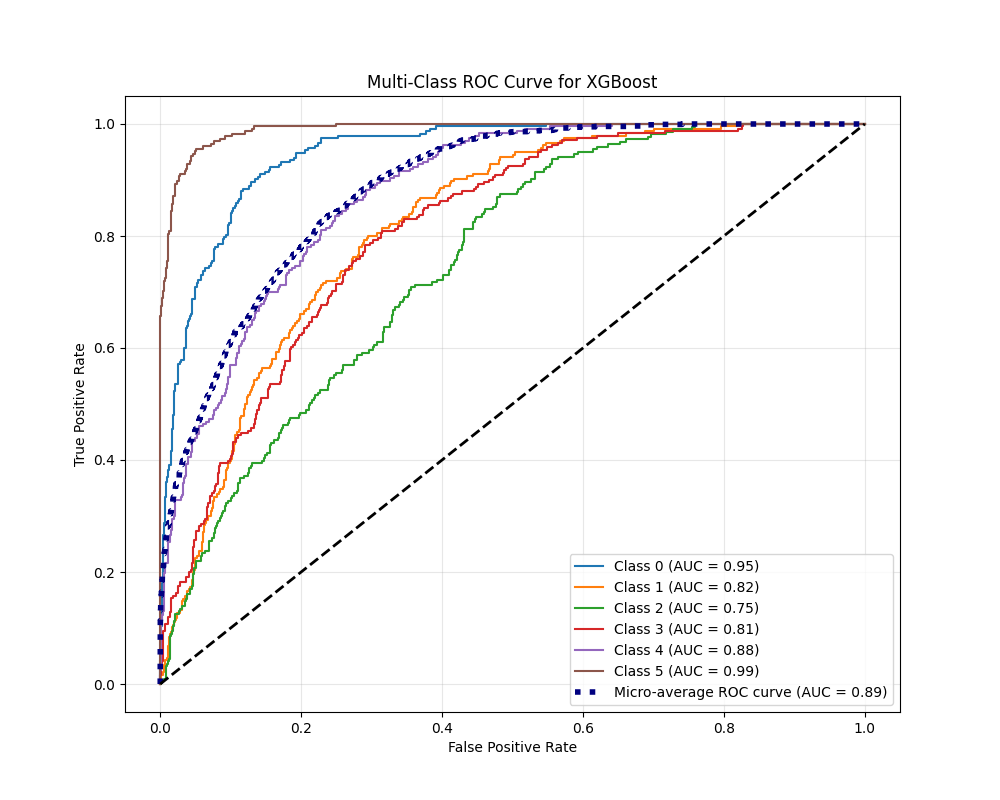

In [44]:
# Get predicted probabilities for all classes
y_pred_proba = xgb_clf.predict_proba(X_test)

# Binarize the output labels for multi-class AUC
y_test_binarized = label_binarize(y_test, classes=[x for x in range(num_buckets)])  # Adjust classes as per your dataset

# Initialize variables for the ROC curves
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and AUC for each class
for i in range(num_buckets):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_buckets):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
         color='navy', linestyle=':', linewidth=4)

# Plot diagonal line for random chance
plt.plot([0, 1], [0, 1], "k--", linewidth=2)

# Add plot details
plt.title("Multi-Class ROC Curve for XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

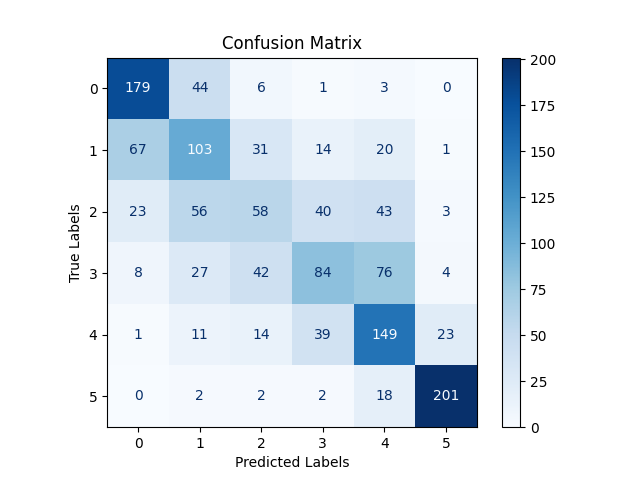

In [40]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot(cmap=plt.cm.Blues)

# Beautify the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [41]:
accuracy = relaxed_accuracy(y_test, y_pred)
print(f"Relaxed Accuracy (±1): {accuracy:.2f}")

Relaxed Accuracy (±1): 0.87


In [42]:
print(relaxed_accuracy_with_weighted_ranges(y_test, y_pred, normalized_bucket_ranges, penalty_weight=3.5))

0.7485816020100301


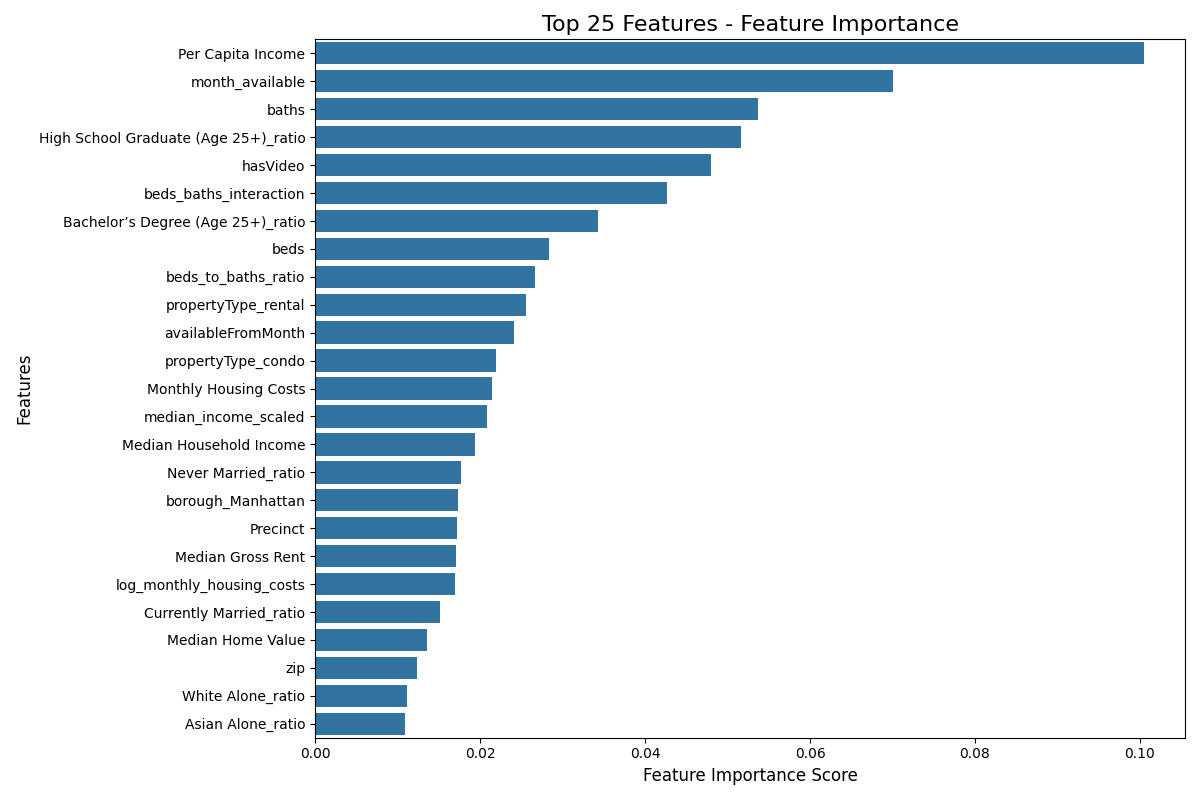

In [43]:
feature_importance = xgb_clf.feature_importances_
feature_names = X_train.columns

# Combine into a DataFrame for easier visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

top_20_features = importance_df.head(25)

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=top_20_features, 
    orient='h'
)

# Customize the plot
plt.title('Top 25 Features - Feature Importance', fontsize=16)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

Accuracy: 0.46


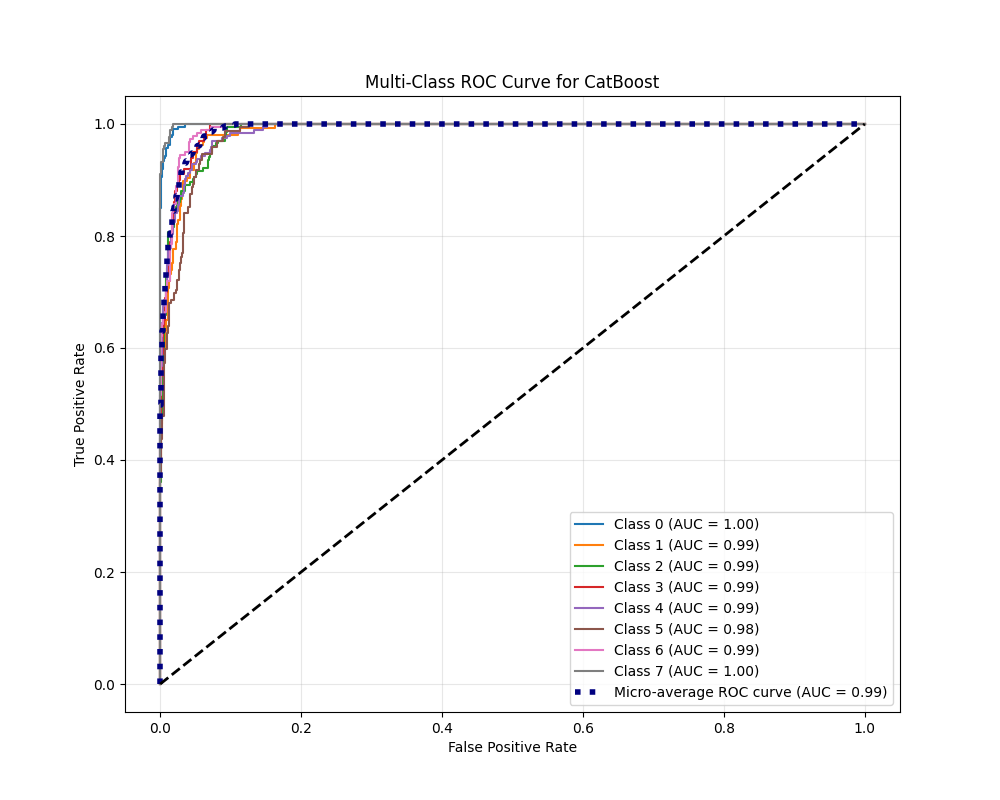

In [78]:


xgb_pred = xgb_clf.predict_proba(X_test)
cat_pred = fin_model.predict_proba(X_test)

xgb_pred = xgb_pred * xgb_accuracy
cat_pred = cat_pred * cat_accuracy

total_pred = xgb_pred + cat_pred

final_pred = np.argmax(total_pred, axis=1)

y_pred_proba = total_pred

accuracy = accuracy_score(y_test, final_pred)
print(f"Accuracy: {accuracy:.2f}")

y_test_binarized = label_binarize(final_pred, classes=[x for x in range(num_buckets)])  # Adjust classes as per your dataset

# Initialize variables for the ROC curves
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and AUC for each class
for i in range(num_buckets):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_buckets):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
        label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color='navy', linestyle=':', linewidth=4)

# Plot diagonal line for random chance
plt.plot([0, 1], [0, 1], "k--", linewidth=2)

# Add plot details
plt.title("Multi-Class ROC Curve for CatBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [81]:
print(relaxed_accuracy(y_test, final_pred))

print(relaxed_accuracy_with_weighted_ranges(y_test, final_pred, normalized_bucket_ranges, bucket_range_relaxation=300, penalty_weight=100))

0.8064516129032258
0.7616455620495302


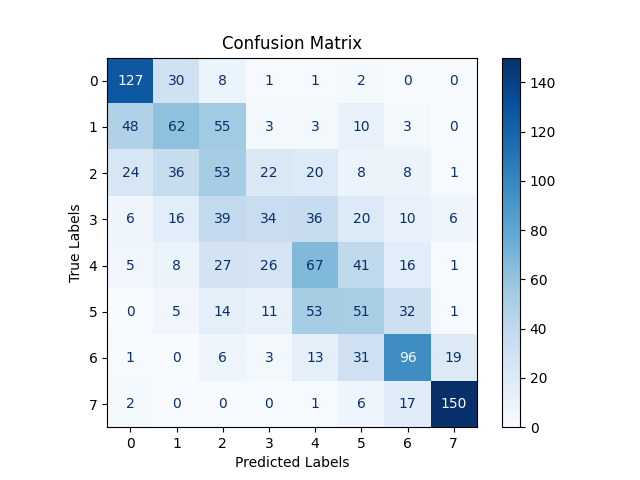

In [82]:
cm = confusion_matrix(y_test, final_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot(cmap=plt.cm.Blues)

# Beautify the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [61]:
# Predict on test data
y_pred = xgb_clf.predict(X_train)

# Generate the classification report
report = classification_report(y_train, y_pred, target_names=[f"Class {i}" for i in range(len(set(y_test)))])
print(report)

              precision    recall  f1-score   support

     Class 0       0.89      0.90      0.89      1871
     Class 1       0.82      0.86      0.84      1846
     Class 2       0.95      0.90      0.92      1859

    accuracy                           0.88      5576
   macro avg       0.89      0.88      0.88      5576
weighted avg       0.89      0.88      0.88      5576



In [69]:
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)  # Use your feature names

# Add predictions and true labels for easier filtering
X_test_df['y_pred'] = y_pred
X_test_df['y_true'] = y_test.values  # Ensure y_test is aligned with X_test

# Filter rows where y_pred == 7 and y_true == 2
mismatch_rows = X_test_df[(X_test_df['y_pred'] == 7) & (X_test_df['y_true'] == 2)]

print(mismatch_rows)
a = pd.DataFrame(rent_df.iloc[1860])
a

      daysOnMarket    zip  beds  baths  latitude  longitude  hasVideo  \
1242           0.0  10010     1    2.0  0.571380   0.505429         1   
1860          33.0  11215     2    1.0  0.400527   0.485413         1   

      PhotosNum  Number of Households  Median Household Income  ...  \
1242   0.096001               16050.0                 0.554058  ...   
1860   2.270820               29465.0                 0.659653  ...   

      crime_to_safety_ratio  beds_to_baths_ratio  diversity_index  \
1242               0.027340             0.066667       -13.766109   
1860               0.070749             0.200000       -73.268788   

      occupied_to_vacant_ratio  availableFromDay  availableFromMonth  \
1242                  1.872145                 1                  12   
1860                  2.547245                 1                   9   

      availableFromYear  Owner-Occupied Units  y_pred  y_true  
1242               2024                   0.0       7       2  
1860         

,1860
daysOnMarket,33.0
availableFrom,2024-09-01
price,2899.0
zip,11215
beds,2
...,...
rent_bucket,2
availableFromDay,1
availableFromMonth,9
availableFromYear,2024
